In [1]:
%%capture
%load_ext autoreload
%autoreload 2
#Basic Imports
import os,sys
os.chdir('/home/asebaq/MSMatch')

from tqdm import tqdm,trange
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
import torch
import pandas as pd

from datasets.ssl_dataset import SSL_Dataset
from datasets.data_utils import get_data_loader
from utils import get_model_checkpoints
from utils import net_builder
from utils import clean_results_df

In [21]:
csv_folder = "/home/asebaq/MSMatch/cvs_folder" #Path where tmp csv files are stored
# folder="/home/asebaq/MSMatch/trained_models/rgb/RGB_50_32/eurosat_rgb/FixMatch_archefficientnet-b0_batch32_confidence0.95_lr0.03_uratio7_wd0.0005_wu1.0_seed0_numlabels50_optSGD"
# folder="/home/asebaq/MSMatch/trained_models/ms/4000/fixmatch/eurosat_ms/FixMatch_archefficientnet-b0_batch64_confidence0.95_lr0.03_uratio7_wd0.0005_wu1.0_seed0_numlabels4000_optSGD"
folder="/home/asebaq/MSMatch/trained_models/ms/50/fixmatch/eurosat_ms/FixMatch_archefficientnet-b0_batch64_confidence0.95_lr0.03_uratio7_wd0.0005_wu1.0_seed0_numlabels50_optSGD"
# folder="/home/asebaq/MSMatch/trained_models/ms/50-ndvi/fixmatch/eurosat_ms/FixMatch_archefficientnet-b0_batch64_confidence0.95_lr0.03_uratio7_wd0.0005_wu1.0_seed0_numlabels50_optSGD"
sort_criterion = "numlabels" # Accepted net, numlabels
seed_wanted = [0,1,2] # Seed wanted (the others will be filtered)

In [22]:
!pwd 

/home/asebaq/MSMatch


## Initialize parameters

In [23]:
checkpoints, run_args = get_model_checkpoints(folder)
if os.name == 'nt':
       [print(_.split("\\")[1]) for _ in checkpoints];
else:
       [print(_.split("/")[1]) for _ in checkpoints];

home


## Run all models

In [28]:
results = []
for checkpoint, args in zip(checkpoints,run_args):
    print("------------ RUNNING ", checkpoint, " -----------------")
    print(args)
    args["batch_size"] = 256
    args["data_dir"] = "/home/asebaq/MSMatch/data/"
    args["use_train_model"] = False
    args["load_path"] = checkpoint
    if args["seed"] in seed_wanted:
        checkpoint_path = os.path.join(args["load_path"])
        checkpoint = torch.load(checkpoint_path,map_location='cuda:0')
        load_model = (checkpoint["train_model"] if args["use_train_model"] else checkpoint["eval_model"])
        _net_builder = net_builder(args["net"],False,{})
        _eval_dset = SSL_Dataset(name=args["dataset"], train=False, data_dir=args["data_dir"], seed=args["seed"])
        eval_dset = _eval_dset.get_dset()
        net = _net_builder(num_classes=_eval_dset.num_classes, in_channels=_eval_dset.num_channels)
        net.load_state_dict(load_model)
        if torch.cuda.is_available():
            net.cuda()
        net.eval()
     
        eval_loader = get_data_loader(eval_dset, args["batch_size"], num_workers=1)
        label_encoding = _eval_dset.label_encoding
        inv_transf = _eval_dset.inv_transform
    
        
        print("------------ PREDICTING TESTSET -----------------")
        
        images, labels, preds = [],[],[]
        with torch.no_grad():
            for image, target in tqdm(eval_loader):
                image = image.type(torch.FloatTensor).cuda()
                logit = net(image)
                for idx,img in enumerate(image):
                    images.append(inv_transf(img.transpose(0,2).cpu().numpy()).transpose(0,2).numpy())
                preds.append(logit.cpu().max(1)[1])
                labels.append(target)
        labels = torch.cat(labels).numpy()
        preds = torch.cat(preds).numpy()
        test_report = classification_report(labels, preds, target_names=label_encoding, output_dict=True)
        test_report["params"] = args
        results.append(test_report)

------------ RUNNING  /home/asebaq/MSMatch/trained_models/ms/50/fixmatch/eurosat_ms/FixMatch_archefficientnet-b0_batch64_confidence0.95_lr0.03_uratio7_wd0.0005_wu1.0_seed0_numlabels50_optSGD/model_best.pth  -----------------
{'dataset': 'eurosat_ms', 'net': 'efficientnet-b0', 'batch': 64, 'confidence': 0.95, 'lr': 0.03, 'uratio': 7, 'wd': 0.0005, 'wu': 1.0, 'seed': 0, 'numlabels': 50, 'opt': 'SGD', 'iterations': 615000, 'batch_size': 256, 'data_dir': '/home/asebaq/MSMatch/data/', 'use_train_model': False, 'load_path': '/home/asebaq/MSMatch/trained_models/ms/50/fixmatch/eurosat_ms/FixMatch_archefficientnet-b0_batch64_confidence0.95_lr0.03_uratio7_wd0.0005_wu1.0_seed0_numlabels50_optSGD/model_best.pth'}
Using not pretrained model efficientnet-b0 ...


100%|██████████| 10/10 [00:52<00:00,  5.30s/it]


------------ PREDICTING TESTSET -----------------


100%|██████████| 11/11 [00:01<00:00,  6.18it/s]


In [29]:
big_df = pd.DataFrame()
pd.set_option('display.max_columns', None)
for result in results:
    params = result["params"]
    df = pd.DataFrame(result)
    df.drop(list(params.keys()),inplace=True)
    df.drop(["support","recall","precision"],inplace=True)
    for key,val in params.items():
        df[key] = val
    df = df.set_index("dataset")
    big_df = big_df.append(df)
# print(big_df)
small_df = clean_results_df(big_df, folder,sort_criterion, keep_per_class=True)
small_df.to_csv(csv_folder + "_test_results.csv")

/tmp/ipykernel_21886/1163100130.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  big_df = big_df.append(df)


In [30]:
csv_folder

'/home/asebaq/MSMatch/cvs_folder'

In [31]:
#small_df = pd.read_csv(csv_folder + "_test_results.csv")
small_df = small_df.drop(labels=["pretrained","supervised","net","accuracy","batch","confidence","lr","uratio","wd","wu","opt","iterations","load_path"],axis=1)
small_df = small_df.groupby('numlabels').mean().reset_index()
# small_df = small_df.set_index("numlabels")
small_df = small_df.reindex(sorted(small_df.columns), axis=1)
small_df = small_df.reset_index()

In [32]:
class_names_dict={'eurosat_rgb' : ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
       'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River',
       'SeaLake'], 'eurosat_ms' : ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
       'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River',
       'SeaLake'], 'ucm' : ["agricultural", "airplane", "baseballdiamond", "beach", "buildings","chaparral","denseresidential","forest", "freeway", "golfcourse","harbor", "intersection", "mediumresidential", "mobilehomepark","overpass","parkinglot","river", "runway", "sparseresidential", "storagetanks", "tenniscourt"]}

Adding info on numlabels per class.

In [33]:
for n in range(len(small_df["numlabels"])):
    small_df["numlabels"][n]=str(small_df["numlabels"][n]) + " (" + str(small_df["numlabels"][n]//len(class_names_dict[args['dataset']]))+")"

/tmp/ipykernel_21886/823274608.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df["numlabels"][n]=str(small_df["numlabels"][n]) + " (" + str(small_df["numlabels"][n]//len(class_names_dict[args['dataset']]))+")"


In [34]:
 small_df

,index,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake,numlabels
0,0,0.973684,0.967742,0.915141,0.97992,0.979757,0.944162,0.91858,0.971993,0.982036,0.993311,50 (5)


In [35]:
l = pd.melt(small_df, id_vars='numlabels', value_vars=class_names_dict[args['dataset']])
l.columns = ["# of labels \n(per class)", "Class", "F1 Score"]

In [36]:
l

,# of labels \n(per class),Class,F1 Score
0,50 (5),AnnualCrop,0.973684
1,50 (5),Forest,0.967742
2,50 (5),HerbaceousVegetation,0.915141
3,50 (5),Highway,0.979920
4,50 (5),Industrial,0.979757
5,50 (5),Pasture,0.944162
6,50 (5),PermanentCrop,0.918580
7,50 (5),Residential,0.971993
8,50 (5),River,0.982036
9,50 (5),SeaLake,0.993311


In [37]:
print(l.to_latex(index=False))

\begin{tabular}{llr}
\toprule
\# of labels \textbackslash n(per class) &                Class &  F1 Score \\
\midrule
                   50 (5) &           AnnualCrop &  0.973684 \\
                   50 (5) &               Forest &  0.967742 \\
                   50 (5) & HerbaceousVegetation &  0.915141 \\
                   50 (5) &              Highway &  0.979920 \\
                   50 (5) &           Industrial &  0.979757 \\
                   50 (5) &              Pasture &  0.944162 \\
                   50 (5) &        PermanentCrop &  0.918580 \\
                   50 (5) &          Residential &  0.971993 \\
                   50 (5) &                River &  0.982036 \\
                   50 (5) &              SeaLake &  0.993311 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_21886/3186058077.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(l.to_latex(index=False))


In [43]:
l.loc[l["Class"]=="Highway"]

,# of labels \n(per class),Class,F1 Score
3,50 (5),Highway,0.98994


In [44]:
l.loc[l["Class"]=="Pasture"]

,# of labels \n(per class),Class,F1 Score
5,50 (5),Pasture,0.967419


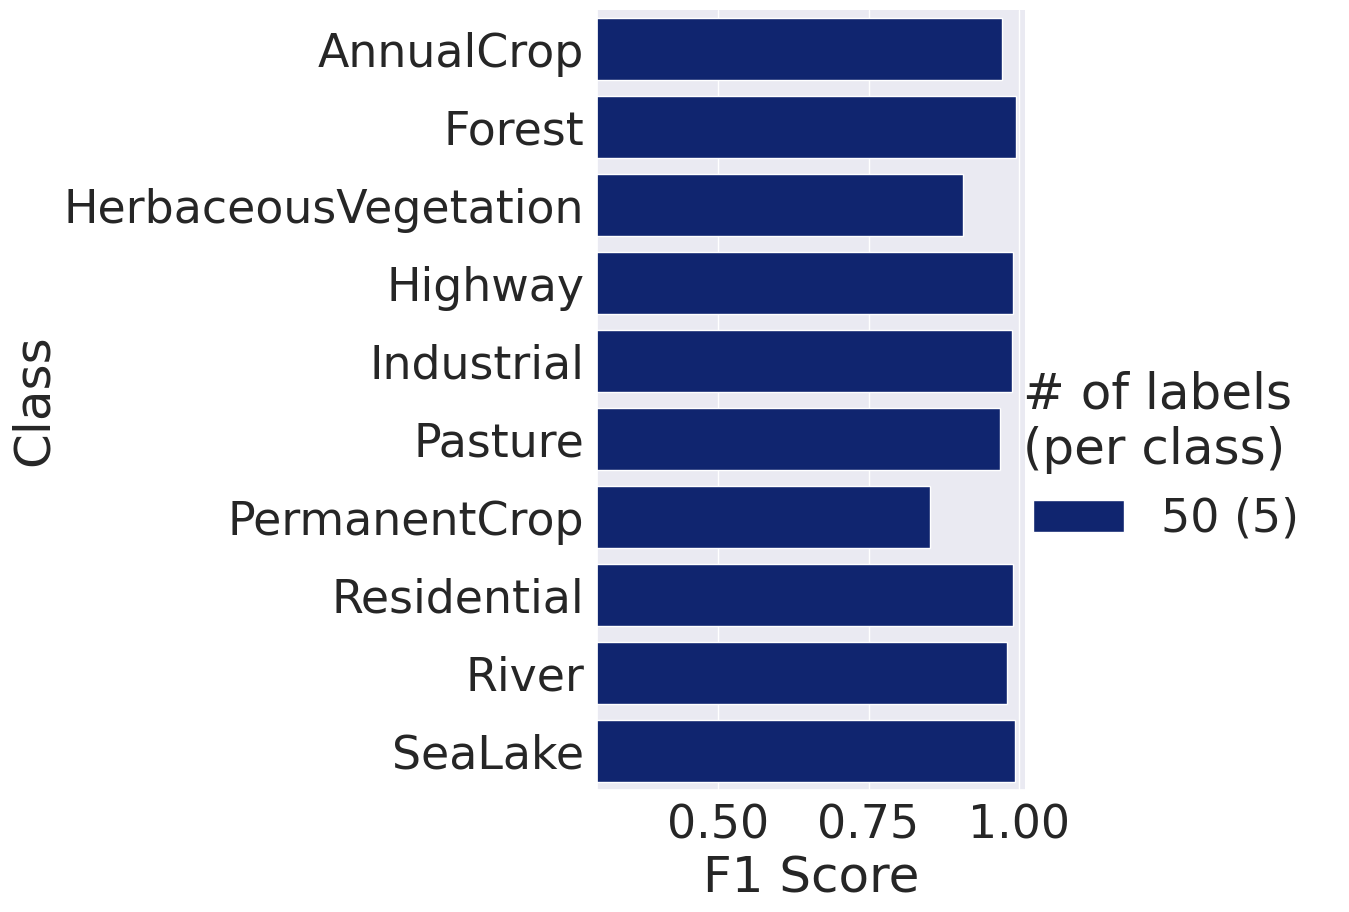

In [45]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()
sns.set(font_scale=3)  # crazy big
with sns.plotting_context():
    p = sns.catplot(x="F1 Score", y="Class", hue="# of labels \n(per class)", data=l, kind="bar",palette="dark",height=10,aspect=1.25)
    # p.set_xticklabels(rotation=90)
    p.set(xlim=[0.3,1.01])

    # p.set(xticks=[0.4,0.6,0.8,1.0])
plt.savefig("class_f1.pdf")

In [20]:
l.loc[l["Class"]==l["Class"][9]]

,# of labels \n(per class),Class,F1 Score
9,50 (5),SeaLake,0.993289


In [21]:
l.loc[l["Class"]=="mediumresidential"]

,# of labels \n(per class),Class,F1 Score
